
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.style as style
import plotly as py
from plotly.offline import init_notebook_mode, iplot
import chart_studio.tools as tls
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split

In [2]:
# loading in popularity data from robintrack.net, which lacks pricing data
# combined and cleaned in another environment due to size issues
df = pd.read_csv('/Users/josephbell/popularity_data.csv')
print(df.shape)
df.head()

(4428700, 3)


,users_holding,Symbol,Date
0,1524,OAS,2018-05-02
1,1517,OAS,2018-05-03
2,1522,OAS,2018-05-04
3,1520,OAS,2018-05-05
4,1520,OAS,2018-05-06


In [3]:
# loading in price data for S&P 500 stocks for the same period
# historical price data was scraped from yahoo finance
df2 = pd.read_csv('/Users/josephbell/combined_prices.csv')
print(df2.shape)
df2.head()

(210101, 4)


,Date,Close,Volume,Symbol
0,2018-05-02,43.860001,23601600.0,CSCO
1,2018-05-03,44.439999,23750200.0,CSCO
2,2018-05-04,45.299999,19504100.0,CSCO
3,2018-05-07,45.730000,17822400.0,CSCO
4,2018-05-08,45.709999,20285300.0,CSCO


In [4]:
# merging the popularity data with pricing data on symbol and date
users_prices = df2.merge(df, how ='inner', on = ('Symbol', 'Date'))
print(users_prices.shape)
users_prices.head()

(203927, 5)


,Date,Close,Volume,Symbol,users_holding
0,2018-05-02,43.860001,23601600.0,CSCO,23646
1,2018-05-03,44.439999,23750200.0,CSCO,23765
2,2018-05-04,45.299999,19504100.0,CSCO,23718
3,2018-05-07,45.730000,17822400.0,CSCO,23552
4,2018-05-08,45.709999,20285300.0,CSCO,23547


In [267]:
# enter ticker of your choice
ticker = 'MCD'
# pulling data out of users_prices for specified ticker
ticker_data = users_prices[users_prices.values == ticker]
ticker_data.reset_index(inplace=True)
# splitting the data by date
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'], infer_datetime_format=True)
train_cutoff = pd.to_datetime('2019-07-01')
val_cutoff = pd.to_datetime('2019-10-01')

train = ticker_data[(ticker_data.Date < train_cutoff )]
val = ticker_data[(ticker_data.Date < val_cutoff) & (ticker_data.Date > train_cutoff)]
test = ticker_data[(ticker_data.Date > val_cutoff)]

# dropping non numeric columns
train = train.drop(columns=['index', 'Symbol', 'Date'])
val = val.drop(columns=['index', 'Symbol', 'Date'])
test = test.drop(columns=['index', 'Symbol', 'Date'])
# get baselines
guess = ticker_data['Close'].mean()
errors = guess - ticker_data['Close']
baseline_mae = errors.abs().mean()
print(f'The mean closing price for {ticker} is {guess:.02f}')
print(f'The mean absolute error is {baseline_mae:.02f}')
print(f'If we just guessed the mean closing price for {ticker} was {guess:.02f}')
print(f'then we would be off by {baseline_mae:.0f} on average.')
print(train.shape, val.shape, test.shape)

The mean closing price for MCD is 185.96
The mean absolute error is 16.38
If we just guessed the mean closing price for MCD was 185.96
then we would be off by 16 on average.
(287, 3) (63, 3) (63, 3)


In [268]:
# arrange data into X features and y target vector 
target = 'Close'
X_train = train.drop(columns=[target])
y_train = train[target]
X_val = val.drop(columns=[target])
y_val = val[target]
X_test = test.drop(columns=[target])
y_test = test[target]

In [269]:
# making a pipeline
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

model = LinearRegression()

model.fit(X_train, y_train)
print('Validation Accuracy', model.score(X_val, y_val))

y_pred = model.predict(X_val)

Validation Accuracy -81.75316808859417


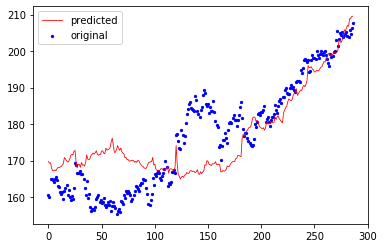

In [270]:
y_pred = model.predict(X_train)
x_ax = range(len(y_train))
plt.scatter(x_ax, y_train, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

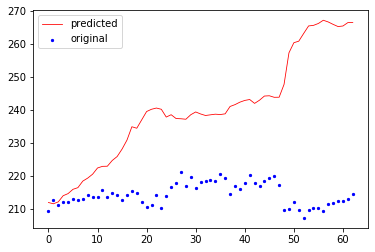

In [271]:
y_pred = model.predict(X_val)
x_ax = range(len(y_val))
plt.scatter(x_ax, y_val, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

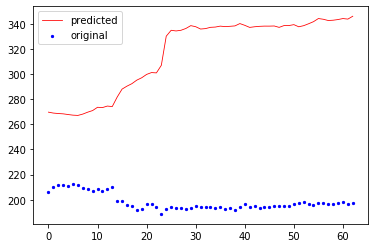

In [272]:
y_pred = model.predict(X_test)
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

In [273]:
# making a pipeline
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

model = xgb.XGBRegressor(objective='reg:squarederror')
    
model.fit(X_train, y_train)
print('Validation Accuracy', model.score(X_val, y_val))

y_pred = model.predict(X_val)

Validation Accuracy -8.782966589547396


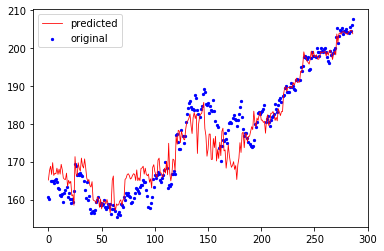

In [274]:
y_pred = model.predict(X_train)
x_ax = range(len(y_train))
plt.scatter(x_ax, y_train, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

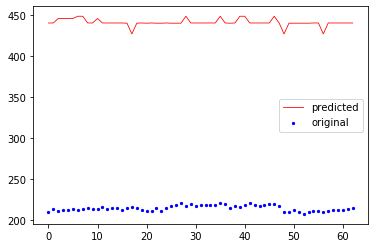

In [275]:
y_pred = pipeline.predict(X_val)
x_ax = range(len(y_val))
plt.scatter(x_ax, y_val, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

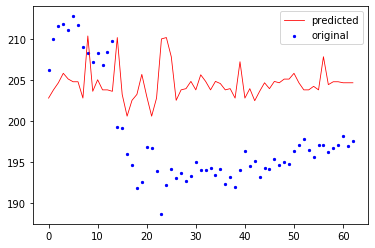

In [276]:
y_pred = model.predict(X_test)
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

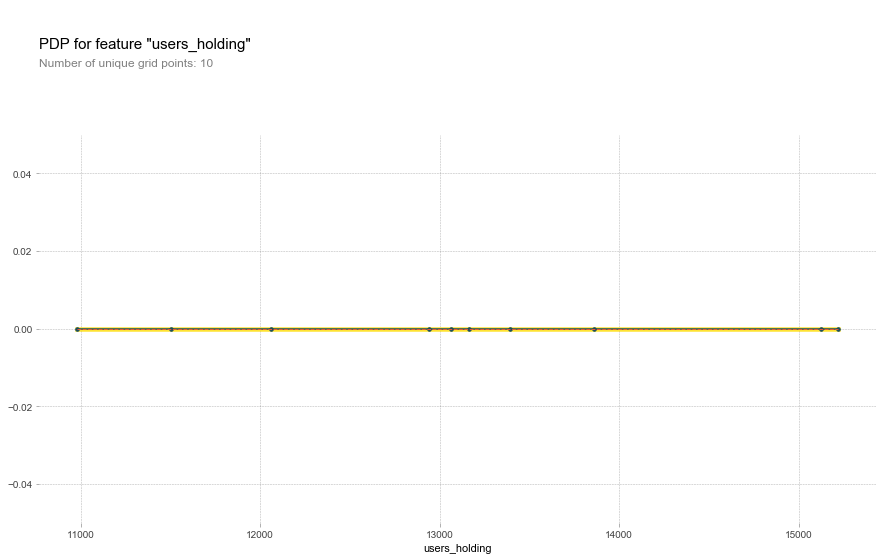

In [277]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'users_holding'

isolated = pdp_isolate(
    model=model,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolated, feature_name = 'users_holding', plot_lines=True,
        frac_to_plot=.01);

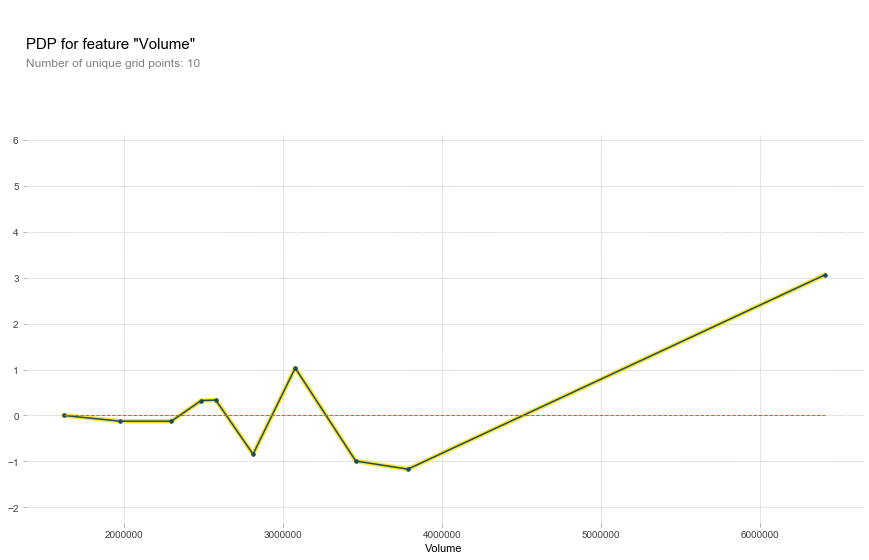

In [278]:
feature = 'Volume'

isolated = pdp_isolate(
    model=model,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolated, feature_name = 'Volume', plot_lines=True,
        frac_to_plot=.01);

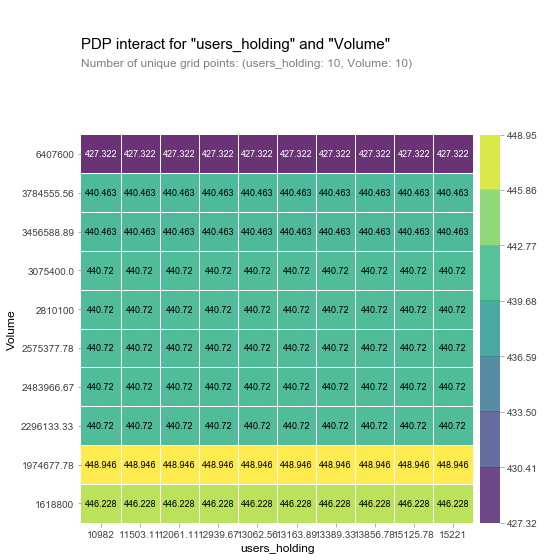

In [279]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['users_holding', 'Volume']

interaction = pdp_interact(
    model=pipeline,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

In [280]:
pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1] 

import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns, 
    y=pdp.index, 
    z=pdp.values
)


layout = go.Layout(
    scene=dict(
        xaxis=dict(title=features[0]), 
        yaxis=dict(title=features[1]), 
        zaxis=dict(title=target)
    )
)

fig = go.Figure(surface, layout)
fig.show()

In [283]:
row = X_test.iloc[[0]]
row

,Volume,users_holding
352,4171400.0,15420


In [284]:
y_test.iloc[[0]]

352    206.270004
Name: Close, dtype: float64

In [285]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap_values

array([[-2.0188894, 28.006393 ]], dtype=float32)

In [286]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)